# Experiment from July 2, 2015. Natural Scenes Analysis.
Structure of stimulus:  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
22.5 min Low contrast binary white noise  
22.5 min High contrast binary white noise  
90 min natural scenes  
10 min of 1 min repeating natural scenes  
5 min high contrast white noise

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import scipy.io
import itertools
import os
import h5py
import pyret
import binary     # in igor >> recording
import pdb

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow

# note that nonposx(y) for log plots will no longer work with this package
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Choose data directory

In [3]:
data_dir = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/')

# Load photodiode  
To align stimulus and recording. The stimulus is briefly (<500ms) a grey screen, followed by a white photodiode for the first frame.

In [4]:
first_bin_file = data_dir + '150702a.bin'
raw_data = binary.readbin(first_bin_file, chanlist=[0])
header   = binary.readbinhdr(first_bin_file)

In [5]:
header['fs']

10000.0

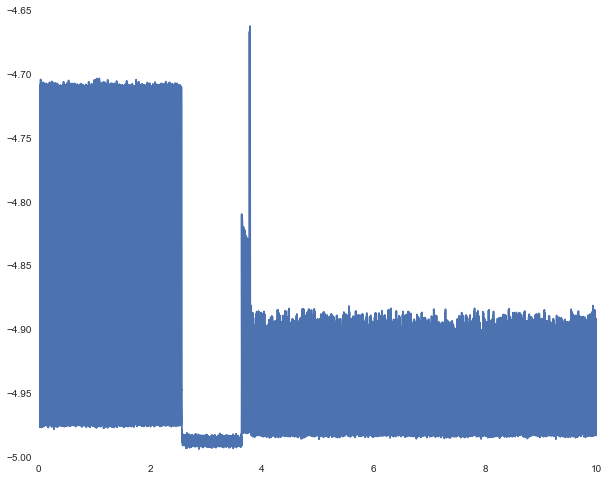

In [6]:
# show first 10 seconds
disp_frames = int(10 * header['fs'])
plot(np.linspace(0, 10, disp_frames), raw_data[:disp_frames])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


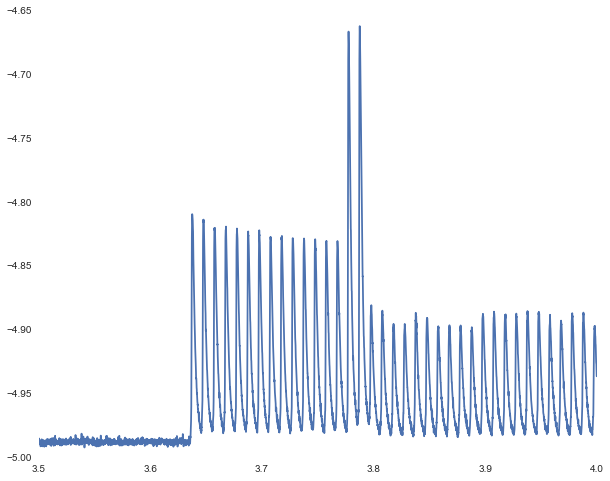

In [7]:
# show 3.5 to 4 seconds
disp_frames_start = 3.5 * header['fs']
disp_frames_end   = 4 * header['fs']
plot(np.linspace(3.5, 4, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


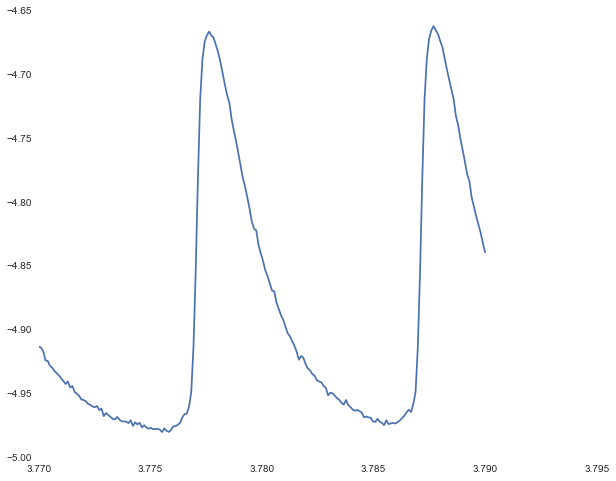

In [8]:
# show 3.77 to 3.79 seconds
disp_frames_start = 3.77 * header['fs']
disp_frames_end   = 3.79 * header['fs']
plot(np.linspace(3.77, 3.79, disp_frames_end - disp_frames_start), raw_data[disp_frames_start:disp_frames_end])

In [9]:
first_white_peak  = np.argmax(raw_data[3.77 * header['fs'] : 3.785 * header['fs']])
first_white_ind   = first_white_peak + 3.77 * header['fs']
time_stim_started = first_white_ind / header['fs']
print 'Stimulus started at %f seconds, relative to recording computer' %(time_stim_started)

Stimulus started at 3.777600 seconds, relative to recording computer


/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/Users/lmcintosh/Git/ipython/IPython/kernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


# Load spikes

In [10]:
fs = sorted(os.listdir(data_dir))
fs = [f for f in fs if f.endswith(".txt")]

cells = []
for f in fs:
    text_file = open(data_dir + f, "r")
    spikes = text_file.read().split('\n')
    cells.append([float(spike) - time_stim_started for spike in spikes if (not (not spike)) and float(spike) - time_stim_started > 0])
    
    text_file.close()

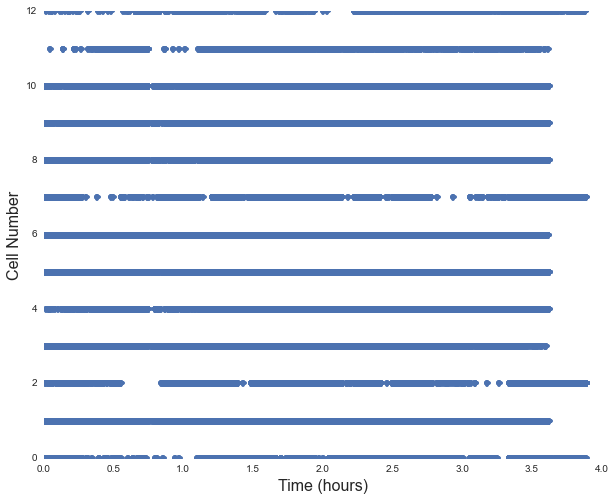

In [11]:
num_cells = len(cells)
all_spiking = np.hstack([ np.vstack((np.array(cell), np.ones(len(cell))*idx)) for idx, cell in enumerate(cells) ]).T
all_spiking.shape

plot(all_spiking[:,0]/(3600.), all_spiking[:,1], 'o')
xlabel('Time (hours)', fontsize=16)
ylabel('Cell Number', fontsize=16)

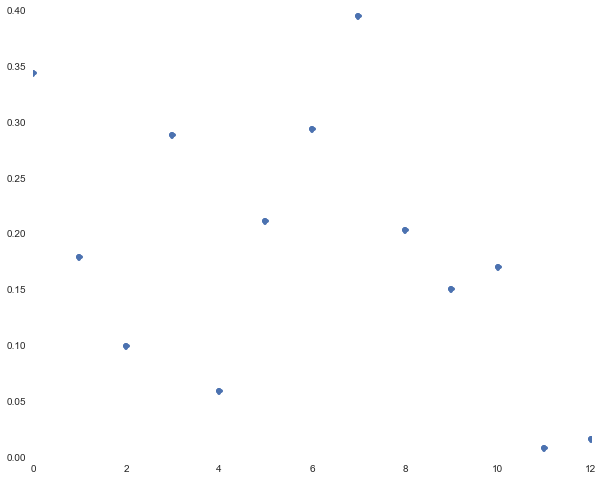

In [12]:
avg_spike_rate = [len(np.array(cells[i])[np.array(cells[i]) < 22.5*60.])/(22.5*60.) for i in range(len(cells))]
plot(avg_spike_rate, 'o')

# Reconstruct natural scenes stimulus  
To naively reconstruct the stimulus frame-by-frame would be >70 GB, so instead we're just going to store the jitter, centers, and image indices.  

Expt5 is natural scenes.  
Expt6 through Expt15 are repeats of the first 1 min of the natural scenes stimulus.  

The HDF5 file in expt5/stim is (nframes, 3) array where dimensions are (image index, xstart, ystart), respectively.

## Load data

In [13]:
stim_file = os.path.expanduser('~/Documents/Stanford/00 Baccus Lab/Data 2015_07_02/natural_scenes_stimulus_norepeats.h5')
f = h5py.File(stim_file)

In [14]:
f.keys()

[u'expt5', u'images']

In [15]:
f['expt5'].keys()

[u'stim', u'timestamps']

#### why are some of the images the same?

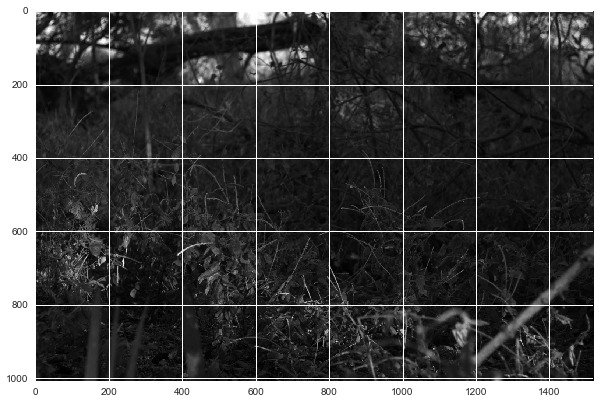

In [32]:
imshow(f['images'][21])

In [16]:
np.max(f['expt5/timestamps'])

5508.4455000000307

In [17]:
np.max(all_spiking)

13995.6787

In [73]:
from __future__ import division
def rescale(x):    
    # note that if python3 division isn't being used, integers will be truncated
    xmin = np.min(x)
    xmax = np.max(x)
    return (x - xmin) / (xmax - xmin)

class NaturalScenesStimulus(object):
    '''Take the compressed natural scenes data and return the appropriate frame(s).'''

    def __init__(self, images, stimulus):
        '''Images should be (num_images, height, width).
        Stimulus should be (num_frames, 3) where the three
        dimensions refer to image index, xstart, ystart.'''
        self.images = images
        self.stimulus = stimulus
        self.ndims = 500

    def __getitem__(self, index):
        #pdb.set_trace()
        img_index = self.stimulus[index, 0].astype('int')
        xstart = self.stimulus[index, 1].astype('int')
        ystart = self.stimulus[index, 2].astype('int')
        # Need to check if index is integer or iterable
        try:
            pdb.set_trace()
            # assume index is a slice
            imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
            return np.array([2*img[x:x+self.ndims, y:y+self.ndims] for x,y,img in zip(xstart,ystart,imgs)])
        except:
            #pdb.set_trace()
            # otherwise index is an integer
            img = rescale(self.images[img_index])
            return 2*self.images[xstart:(xstart + self.ndims), ystart:(ystart + self.ndims)]

In [74]:
natural_stimuli = NaturalScenesStimulus(f['images'], f['expt5/stim'])

> <ipython-input-73-2f76a402060a>(28)__getitem__()
-> imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
(Pdb) n
> <ipython-input-73-2f76a402060a>(28)__getitem__()
-> imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
(Pdb) [img.shape for img in imgs]
*** NameError: name 'imgs' is not defined
(Pdb) n
> <ipython-input-73-2f76a402060a>(28)__getitem__()
-> imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
(Pdb) n
> <ipython-input-73-2f76a402060a>(28)__getitem__()
-> imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
(Pdb) n
> <ipython-input-73-2f76a402060a>(28)__getitem__()
-> imgs = [rescale(self.images[img_idx]) for img_idx in img_index]
(Pdb) n
> <ipython-input-73-2f76a402060a>(29)__getitem__()
-> return np.array([2*img[x:x+self.ndims, y:y+self.ndims] for x,y,img in zip(xstart,ystart,imgs)])
(Pdb) [img.shape for img in imgs]
[(1007, 1519), (1007, 1519), (1007, 1519), (1007, 1519)]
(Pdb) xstart
array([968, 970, 970, 968])
(Pdb) 1007-9

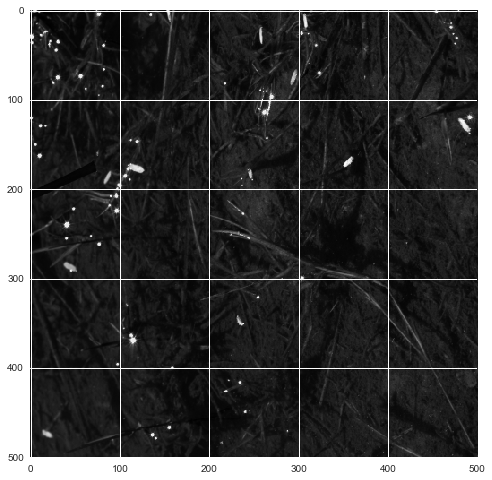

(Pdb) q


TypeError: PointSelection __getitem__ only works with bool arrays

In [75]:
natural_stimuli[1:5][0].shape

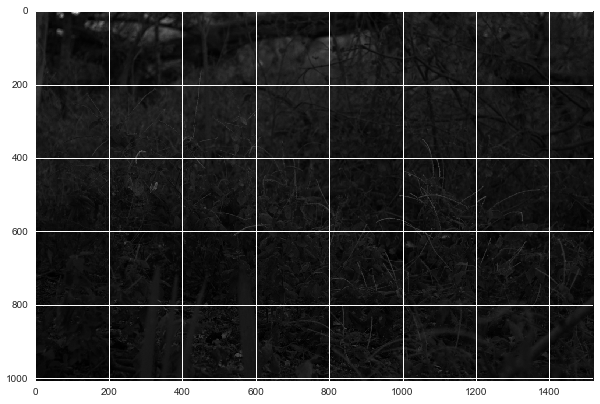

In [53]:
imshow(f['images'][24])

In [55]:
[lol.shape for lol in f['images']]

[(1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519),
 (1007, 1519)]

In [56]:
lin = np.arange(1529633).reshape((1007, 1519))

In [61]:
img_index = f['expt5/stim'][:, 0].astype('int')
xstart = f['expt5/stim'][:, 1].astype('int')
ystart = f['expt5/stim'][:, 2].astype('int')

In [67]:
np.max([x + 500 - 1519 for x in xstart])

0

In [68]:
np.max([y + 500 - 1007 for y in ystart])

0

In [69]:
[y + 500 - 1007 for y in ystart]

[0,
 -2,
 -3,
 -2,
 -3,
 -2,
 -1,
 -2,
 -1,
 -1,
 0,
 0,
 0,
 0,
 -1,
 0,
 0,
 -1,
 -1,
 -2,
 -4,
 -5,
 -4,
 -3,
 -2,
 -1,
 -1,
 -1,
 -1,
 0,
 0,
 -1,
 -1,
 0,
 0,
 0,
 0,
 -1,
 -4,
 -5,
 -6,
 -3,
 -5,
 -3,
 -7,
 -5,
 -3,
 -2,
 -1,
 -2,
 -1,
 -2,
 -2,
 -4,
 -5,
 -5,
 -6,
 -4,
 -8,
 -8,
 -6,
 -6,
 -6,
 -5,
 -6,
 -5,
 -5,
 -8,
 -7,
 -5,
 -5,
 -3,
 -2,
 -3,
 -2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -1,
 -1,
 0,
 0,
 0,
 -1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -6,
 -7,
 -7,
 -7,
 -9,
 -8,
 -6,
 -6,
 -3,
 -1,
 -4,
 -4,
 -1,
 0,
 0,
 -2,
 0,
 -2,
 -1,
 -1,
 -2,
 -3,
 -5,
 -5,
 -5,
 -8,
 -8,
 -7,
 -10,
 -7,
 -7,
 -5,
 -6,
 -3,
 -5,
 -5,
 -6,
 -6,
 -8,
 -7,
 -6,
 -7,
 -8,
 -10,
 -12,
 -9,
 -9,
 -5,
 -6,
 -7,
 0,
 0,
 -1,
 0,
 0,
 -1,
 -3,
 0,
 0,
 0,
 0,
 -1,
 0,
 -2,
 -3,
 -4,
 -3,
 -4,
 -2,
 -4,
 -3,
 -2,
 -1,
 -2,
 0,
 -1,
 -2,
 -1,
 0,
 0,
 -1,
 0,
 -2,
 -2,
 -1,
 -2,
 -1,
 0,
 -1,
 -3,
 -3,
 -3,
 -5,
 -8,
 -7,
 -7,
 -7,
 -6,
 -8,
 -6,
 -2,
 -3,
 -4,
 -5,
 -4,
 -3,
 -5,
 -3,
 -2,
 -1,

In [63]:
ystart.shape

(269833,)